# Results 2c: Metric Validation

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from pandas import read_csv
from tqdm import tqdm
sns.set_style('white')
sns.set_context('notebook', font_scale=1.33)
%matplotlib inline

## Section 1: Load and prepare data

In [8]:
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define subscales.
subscales = {
    '7u':    ['7u7d-q01','7u7d-q03','7u7d-q04','7u7d-q06','7u7d-q07','7u7d-q08','7u7d-q13'],
    '7d':    ['7u7d-q02','7u7d-q05','7u7d-q09','7u7d-q10','7u7d-q11','7u7d-q12','7u7d-q14'],
    'gad7':  ['gad7-q01','gad7-q02','gad7-q03','gad7-q04','gad7-q05','gad7-q06','gad7-q07'],
    'bis':   ['bisbas-q01','bisbas-q02','bisbas-q03','bisbas-q04'],
    'bas-r': ['bisbas-q05','bisbas-q06','bisbas-q07','bisbas-q08'],
    'bas-d': ['bisbas-q09','bisbas-q10','bisbas-q11','bisbas-q12'],
    'shaps': ['shaps-q01','shaps-q02','shaps-q03','shaps-q04','shaps-q05',
              'shaps-q06','shaps-q07','shaps-q08','shaps-q09','shaps-q10',
              'shaps-q11','shaps-q12','shaps-q13','shaps-q14'],
    'pswq':  ['pswq-q01','pswq-q02','pswq-q03']
}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Load and prepare data.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Load reject data.
metrics = read_csv(os.path.join('data','metrics.csv'))

## Load survey data.
surveys = read_csv(os.path.join('data','surveys.csv'))

## Restrict participants.
surveys = surveys.loc[surveys.subject.isin(metrics.subject)]
    
## Merge infrequency items.
surveys = surveys.merge(metrics[['platform','subject','infreq']])
surveys['infreq'] = np.where(surveys['infreq'], 1, 0)

## Restrict survey to valid items.
items = surveys[['platform','subject','infreq']+np.concatenate([*subscales.values()]).tolist()]

KeyError: "['bisbas-q10', 'shaps-q01', '7u7d-q05', 'gad7-q01', 'shaps-q12', 'shaps-q08', 'gad7-q03', 'gad7-q02', '7u7d-q03', '7u7d-q10', '7u7d-q12', 'shaps-q05', 'bisbas-q05', 'pswq-q02', 'pswq-q03', 'bisbas-q08', 'shaps-q09', 'bisbas-q06', 'gad7-q05', 'shaps-q13', '7u7d-q08', '7u7d-q02', 'bisbas-q11', '7u7d-q07', 'shaps-q10', 'shaps-q02', '7u7d-q14', 'bisbas-q01', 'bisbas-q03', 'bisbas-q09', 'bisbas-q04', 'gad7-q06', 'pswq-q01', '7u7d-q09', 'shaps-q04', '7u7d-q06', 'bisbas-q02', '7u7d-q13', 'gad7-q04', 'gad7-q07', 'shaps-q14', 'shaps-q03', '7u7d-q04', 'shaps-q11', 'bisbas-q07', 'bisbas-q12', '7u7d-q01', 'shaps-q07', 'shaps-q06', '7u7d-q11'] not in index"

## Section 2: Rates of Clinical Endorsement 

In [5]:
from pandas import DataFrame
from scipy.stats import skew

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define cutoff scores.
cutoffs = {'7u':12, '7d':12, 'gad7':10, 'bis':0, 'bas-r':0, 'bas-d':0, 'shaps':3, 'pswq':11}

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute total scores.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Iteratively compute sum scores.
for i, (k, v) in enumerate(subscales.items()):
    surveys[k] = surveys[v].sum(axis=1)
    
## Restrict survey to valid items.
items = surveys[['platform','subject','infreq']+np.concatenate([*subscales.values()]).tolist()]

## Melt DataFrame.
scores = surveys[['platform','subject','infreq']+list(subscales.keys())].copy()
scores['shaps95'] = (items[subscales['shaps']] >= 2).sum(axis=1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute summary statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
table = np.zeros((len(subscales), 7)) * np.nan

## Iteratively compute summary statistics.
for i, (k, v) in enumerate(cutoffs.items()):
    
    ## Compute skew.
    table[i,0] = skew(scores[k])
    
    ## Compute total scores.
    table[i,1:3] = scores.groupby('infreq')[k].mean()
    
    ## Compute proportion at threshold.
    if k == 'shaps': 
        table[i,3:5] = scores.groupby('infreq')['shaps95'].apply(lambda x: np.mean(x >= v))
    elif v: 
        table[i,3:5] = scores.groupby('infreq')[k].apply(lambda x: np.mean(x >= v))
        
## Store Cronbach alpha.
table[:,5] = alpha_0
table[:,6] = alpha_1

## Convert to DataFrame.
table = DataFrame(table, index=cutoffs.keys())
table.round(2)

,0,1,2,3,4,5,6
7u,0.81,3.87,10.15,0.04,0.45,0.84,0.84
7d,0.76,4.75,10.68,0.09,0.46,0.94,0.88
gad7,0.75,4.86,9.73,0.17,0.56,0.92,0.87
bis,0.78,7.74,7.92,NaN,NaN,0.83,0.62
bas-r,0.59,6.38,7.38,NaN,NaN,0.71,0.60
bas-d,0.05,9.35,8.79,NaN,NaN,0.86,0.69
shaps,0.26,8.02,10.85,0.15,0.29,0.90,0.81
pswq,0.19,4.78,6.74,0.07,0.08,0.93,0.81


## Section 3: Cronbach's Alpha


In [3]:
from scipy.stats import ttest_rel
from numba import njit

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define parameters.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Define number of permutations.
n_iter = 5000

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Define useful functions.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

@njit
def cronbach_alpha(X):
    "Estimate Cronbach's alpha for X, [n_obs, n_features]"
    n, k = X.shape
    C = np.cov(X.T)
    return (k / (k - 1)) * (1 - np.trace(C) / np.sum(C))

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Compute observed statistics.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#

## Preallocate space.
alpha_0 = np.zeros(len(subscales))
alpha_1 = np.zeros(len(subscales))

## Iteratively compute Cronbach's alpha.
for i, cols in enumerate(subscales.values()):
    alpha_0[i] = cronbach_alpha(items.loc[items.infreq==0,cols].values)
    alpha_1[i] = cronbach_alpha(items.loc[items.infreq==1,cols].values)
    
## Compute test statistic.
tval, _ = ttest_rel(alpha_0, alpha_1)

#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
### Permutation testing.
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~#
np.random.seed(47404)

## Preallocate space
null_tvals = np.zeros(n_iter)

## Main loop.
permuted = items.copy()
for n in tqdm(range(n_iter)):
    
    ## Preallocate space.
    alpha_null = np.zeros((2, len(subscales))) 
    
    ## Permute rows of infrequncy score.
    permuted.infreq = np.random.permutation(permuted.infreq)
    
    ## Iteratively compute Cronbach's alpha.
    for i, cols in enumerate(subscales.values()):
        alpha_null[0,i] = cronbach_alpha(permuted.loc[permuted.infreq==0,cols].values)
        alpha_null[1,i] = cronbach_alpha(permuted.loc[permuted.infreq==1,cols].values)
        
    ## Compute test statistic.
    null_tvals[n], _ = ttest_rel(alpha_null[0], alpha_null[1])
    
## Compute p-value.
pval = (np.abs(tval) <= np.abs(null_tvals)).sum() / (n_iter + 1)

100%|██████████| 5000/5000 [02:05<00:00, 39.74it/s]


In [4]:
## Report outcomes.
print('no flag', alpha_0.round(3))
print('flagged', alpha_1.round(3))
print('tval = %0.3f, pval = %0.3f' %(tval,pval))

no flag [0.836 0.937 0.924 0.83  0.708 0.862 0.904 0.934]
flagged [0.838 0.882 0.872 0.624 0.599 0.691 0.812 0.807]
tval = 4.247, pval = 0.006


## Section 4: Rasch Model

In [24]:
from pandas import read_csv

## Load Stan results.
stan_results = read_csv('stan_results/1pl_logistic.tsv', sep='\t')

## Restrict to intercepts.
intercepts = stan_results.filter(regex='Z\[[0-9]*,1\]').median().values

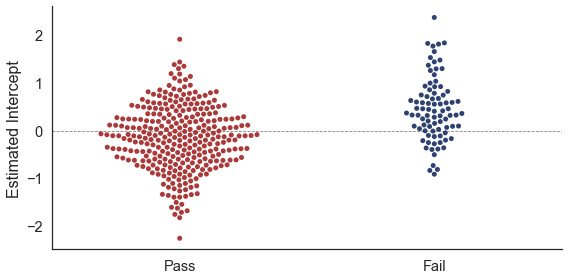

In [34]:
## Initialize canvas.
fig, ax = plt.subplots(1,1,figsize=(8,4))

## Plot distribution of intercepts.
ax = sns.swarmplot(x=np.where(metrics.infreq,1,0), y=intercepts, palette=['#AA3939','#2E4272'], ax=ax)
ax.axhline(0, lw=0.8, linestyle='--', color='0.5', zorder=-1)

## Add details.
ax.set(xticklabels=['Pass','Fail'], ylabel='Estimated Intercept')

sns.despine()
plt.tight_layout()

array([1, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0,
       1, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,

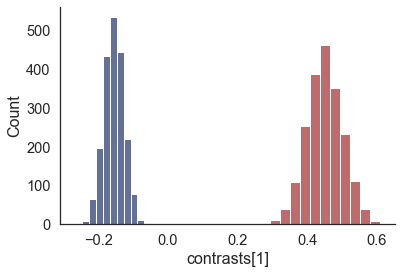

In [14]:
sns.histplot(contrasts['contrasts[1]'], bins=11, color='#2E4272')
sns.histplot(contrasts['contrasts[2]'], bins=11, color='#AA3939')
sns.despine()

In [15]:
contrasts

,lp__,accept_stat__,stepsize__,treedepth__,n_leapfrog__,divergent__,energy__,"Z[1,1]","Z[2,1]","Z[3,1]",...,"kappa[41,3]","kappa[42,3]","kappa[43,3]","kappa[44,3]","kappa[45,3]","kappa[46,3]","kappa[47,3]",contrasts[1],contrasts[2],contrasts[3]
0,-36719.3,0.914766,0.158844,5.0,31.0,0.0,38352.2,0.784935,-0.530150,-0.711793,...,0.347783,0.566960,-0.160959,0.288052,-0.199031,0.338422,0.336938,-0.089090,0.433660,-0.522750
1,-36689.9,0.583659,0.158844,5.0,31.0,0.0,38432.1,0.625119,0.346690,-0.590955,...,0.378852,0.482004,-0.131876,0.364336,0.070626,0.244031,0.435909,-0.144625,0.463319,-0.607944
2,-36735.8,0.746077,0.158844,5.0,31.0,0.0,38350.6,1.731610,-0.251095,-1.760040,...,0.304049,0.587261,-0.063609,0.416967,-0.002340,0.328372,0.389475,-0.140796,0.440872,-0.581668
3,-36647.4,0.909791,0.158844,5.0,31.0,0.0,38285.4,1.417350,-0.067143,-1.177170,...,0.448470,0.465571,-0.275345,0.371395,-0.001827,0.296707,0.316434,-0.092130,0.482669,-0.574799
4,-36655.7,0.534360,0.158844,5.0,31.0,0.0,38305.9,0.341335,-0.041771,-1.163170,...,0.256860,0.594045,-0.037413,0.363536,-0.029433,0.310068,0.424845,-0.160409,0.409996,-0.570405
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,-36684.3,0.691286,0.153038,5.0,31.0,0.0,38218.6,0.685333,-0.230271,-0.407721,...,0.373877,0.376971,-0.128591,0.337127,0.014251,0.275709,0.373926,-0.189618,0.469660,-0.659278
1996,-36751.6,0.518100,0.153038,5.0,31.0,0.0,38374.8,0.598199,-0.187169,-1.202880,...,0.235470,0.513073,-0.192874,0.373291,0.024785,0.330303,0.322740,-0.172812,0.426026,-0.598837
1997,-36777.2,0.921943,0.153038,5.0,31.0,0.0,38377.6,0.898862,-0.211860,-0.782750,...,0.384808,0.582090,-0.148521,0.300537,-0.030501,0.250585,0.438918,-0.158805,0.410112,-0.568917
1998,-36707.9,0.987642,0.153038,5.0,31.0,0.0,38353.7,0.236215,-0.368988,-1.123330,...,0.214430,0.525008,-0.211001,0.197211,-0.102176,0.293645,0.391389,-0.174389,0.444770,-0.619159
